In [1]:
from astropy.table import Table, vstack, Column, MaskedColumn, pprint
import numpy as np

import matplotlib 
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel

from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages

import os
import requests
import sys
sys.path.append('/Users/s2537809/DESI/desispec/py')
sys.path.append('/Users/s2537809/DESI/desimodel/py')
sys.path.append('/Users/s2537809/DESI/desitarget/py')
sys.path.append('/Users/s2537809/DESI/desiutil/py')

#from desispec.io import read_spectra
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra

# DESI targeting masks - 
from desitarget.sv1 import sv1_targetmask    # For SV1
from desitarget.sv2 import sv2_targetmask    # For SV2
from desitarget.sv3 import sv3_targetmask    # For SV3

from scipy import interpolate
import astropy.units as u
path='/Users/s2537809/Documents/DESI-STACKING'#specify code directory
os.chdir(path)
import stack_code as sc
import importlib
import fnmatch
import extinction as ext
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy.modeling import models
from astropy.table import Table
from matplotlib import gridspec
import spectres
import time
import warnings

#pip install lmfit, extinction, sfdmap, spectres

import pandas as pd
crossmatch = Table.read('crossmatch_classifications.fits', format = 'fits' )

/Users/s2537809/DESI/desispec/py/desispec/qproc/qextract.py:19: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def numba_extract(image_flux,image_var,x,hw=3) :
/Users/s2537809/DESI/desispec/py/desispec/image_model.py:27: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def numba_proj(image,x,sigma,flux) :
/Users/s2537809/DESI/desispec/py/desispec/preproc.py:379: Num

In [2]:
""" 
Remove the objects with failed redshfit classifications.
First appplying their ZWARN flag, then with the photo-z quality flag.
"""

# Apply ZWARN Flag cut
crossmatch = crossmatch[crossmatch['ZWARN'] == 0]

# Create photo-z quality flag
crossmatch['Z_CHECK']= (crossmatch['Z']-crossmatch['Z_BEST_1'])/(1+crossmatch['Z'])
crossmatch['Z_FAILURE'] = 0  
crossmatch['Z_FAILURE'][abs(crossmatch['Z_CHECK']) > 0.1] = 1 

# Apply photo-z quality flag
crossmatch = crossmatch[crossmatch['Z_FAILURE'] == 0]
print(len(crossmatch))
print(len(crossmatch[crossmatch['Z'] < 0]))

7533
27


## Cell below verifies if Spectra are downloaded and downloads if they aren't

Only run if unsure if spectra are downloaded, to save time!

In [2]:
"""
Note: The lengths for indexing are:

HERG = 184

RQAGN = 814

LERG = 1293

SFG = 6294

"""


Overall_class = 'SFG'
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][1000:1200]
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])



def select_data(table, column_name, search_values):
    # Get the column data as a numpy array
    column_data = table[column_name]

    SURVEY = []
    PROGRAM = []
    HEALPIX = []
    n_values = []
    Z = []
    

    for search_value in search_values:
        # Find the indices where the condition is met (value == search_value)
        indices = np.where(column_data == search_value)[0]


        if len(indices) > 0:
            # Find the corresponding Survey, program, healpix, and Z values
            SURVEY.append(table['SURVEY'][indices[0]])
            PROGRAM.append(table['PROGRAM'][indices[0]])
            HEALPIX.append(table['HEALPIX'][indices[0]])
            Z.append(table['Z'][indices[0]])
            HEALPIX_str = str(table['HEALPIX'][indices[0]])
            n_str = HEALPIX_str[:3]
            n_values.append(int(n_str))
        else:
            # Handle the case where the search value was not found
            SURVEY.append(None)
            PROGRAM.append(None)
            HEALPIX.append(None)
            n_values.append(None)
            Z.append(None)
    

    return np.array(SURVEY), np.array(PROGRAM), np.array(HEALPIX), np.array(n_values), np.array(Z), 


SURVEY = select_data(my_table, search_column_name, search_values)[0]
PROGRAM = select_data(my_table, search_column_name, search_values)[1]
HEALPIX = select_data(my_table, search_column_name, search_values)[2]
n = select_data(my_table, search_column_name, search_values)[3]
Z = select_data(my_table, search_column_name, search_values)[4]
print (SURVEY,PROGRAM,HEALPIX, n, Z)

for n, survey, program, healpix, Z, search_value in zip(n, SURVEY, PROGRAM, HEALPIX, Z, search_values):
        #download the file from the given Target ID
        target_url = f"https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/healpix/{survey}/{program}/{n}/{healpix}/coadd-{survey}-{program}-{healpix}.fits"
        
        # Define the folder name and file name
        folder_name = 'DESI_Downloads'
        file_name = f"coadd-{survey}-{program}-{healpix}.fits"
        print(search_value)


        # Check if the folder exists, and create it if it doesn't
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        # Check if the file exists in the folder
        file_path = os.path.join(folder_name, file_name)
        if os.path.exists(file_path):
            print(f"{file_name} already exists in {folder_name}. No need to download.")
        else:
            # File doesn't exist, download it
            try:
                response = requests.get(target_url)
                if response.status_code == 200:
                    with open(file_path, 'wb') as file:
                        file.write(response.content)
                    print(f"{file_name} downloaded to {folder_name}.")
                else:
                    print(f"Failed to download {file_name}. Status code: {response.status_code}")
            except Exception as e:
                print(f"An error occurred while downloading {file_name}: {str(e)}")

      

['sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3'
 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1' 'sv1'
 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv1' 'sv1' 'sv1' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv1' 'sv1' 'sv1' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 's

In [31]:
def inv_var_weighted_average(flux1, ivar1, flux2, ivar2):
    """
    Finds the inverse varience weighted average of two flux spectra
    
    """
    weight1 = 1 / ivar1
    weight2 = 1 / ivar2
    total_weight = weight1 + weight2
    weighted_flux1 = flux1 * (weight1 / total_weight)
    weighted_flux2 = flux2 * (weight2 / total_weight)
    weighted_avg = weighted_flux1 + weighted_flux2
    return weighted_avg

def no_overlap_f(waveb,fluxb,waver,fluxr,wavez,fluxz):
    """
    Isolates the flux and wavelength arrays of each band to non-overlapping wavelength sections
    
    """
    new_b_length = np.where(waveb<waver[0])
    b_wave = waveb[new_b_length]
    b_flux = fluxb[new_b_length]
    new_r_length = np.where((waver>waveb[-1])&(waver<wavez[0]))
    r_wave = waver[new_r_length]
    r_flux = fluxr[new_r_length]
    new_z_length = np.where(wavez>waver[-1])
    z_wave = wavez[new_z_length]
    z_flux = fluxz[new_z_length]

    return b_wave,b_flux,r_wave,r_flux,z_wave,z_flux


def overlap_av(wave1,wave2,flux1,flux2,ivar1,ivar2):
    """
    Finds the overlap of two wavelength ranges.
    Computes the inverse var weighted average flux and wavelength for th eoverlapping range 
    
    """
    overlap_idx_1 = np.where(wave1 >= wave2[0]) 
    overlap_wave = wave1[overlap_idx_1]
    overlap_flux_1 = flux1[overlap_idx_1]
    overlap_ivar_1 = ivar1[overlap_idx_1]

    overlap_idx_2 = np.where(wave2 <= wave1[-1]) 
    overlap_flux_2 = flux2[overlap_idx_2]
    overlap_ivar_2 = ivar2[overlap_idx_2]
    
    overlap_av_flux = inv_var_weighted_average(overlap_flux_1,overlap_ivar_1,overlap_flux_2,overlap_ivar_2)

    return overlap_av_flux, overlap_wave

In [32]:
#stacking functions

# Ignore warnings due to spec_var=0
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")


def get_spectra(table, column_name, search_values): 
    print('Number of spectra =', len(table))
    # Get the Target IDs as a numpy array
    column_data = table[column_name]

    SURVEY, PROGRAM, HEALPIX, n_values = [], [], [], []
    Z, RA, DEC, Source_ID = [], [], [], []


    for search_value in search_values:
        # Find the indices where the condition is met (value == search_value)
        # This is only relevant if input is doen by search value and not selected table
        indices = np.where(column_data == search_value)[0]

        if len(indices) > 0:
            # Find the corresponding Survey, program, healpix, Z , RA and Dec values
            SURVEY.append(table['SURVEY'][indices[0]])
            PROGRAM.append(table['PROGRAM'][indices[0]])
            HEALPIX.append(table['HEALPIX'][indices[0]])
            Z.append(table['Z'][indices[0]])
            RA.append(table['TARGET_RA'][indices[0]]) 
            DEC.append(table['TARGET_DEC'][indices[0]])
            Source_ID.append(table['TARGETID'][indices[0]])
            HEALPIX_str = str(table['HEALPIX'][indices[0]])
            n_str = HEALPIX_str[:3]
            n_values.append(int(n_str))
        else:
            # Handle the case where the search value was not found
            SURVEY.append(None)
            PROGRAM.append(None)
            HEALPIX.append(None)
            n_values.append(None)
            Z.append(None)   
            RA.append(None)
            DEC.append(None)
            Source_ID.append(None)
            
    
    z = np.array(Z)
    RA = np.array(RA)
    DEC = np.array(DEC)
    id_spec = np.array(Source_ID)
    wave_spec, flux_spec, sigma_spec = [], [], []
    
    for index, (survey, program, healpix, search_value) in enumerate(zip(SURVEY, PROGRAM, HEALPIX, search_values)):
        
        folder_name = 'DESI_Downloads'
        file_name = f"coadd-{survey}-{program}-{healpix}.fits"
        coadd_obj = desispec.io.read_spectra(f'{folder_name}/{file_name}')
        coadd_tgts = coadd_obj.target_ids().data
        # Selecting the particular spectra of the targetid
        row = (coadd_tgts == search_value)
        coadd_spec = coadd_obj[row] 

        # Inverse Vartiance weighted average for overlap
        no_overlap = no_overlap_f(coadd_spec.wave['b'],coadd_spec.flux['b'][0],coadd_spec.wave['r'],coadd_spec.flux['r'][0],coadd_spec.wave['z'],coadd_spec.flux['z'][0])
        overlap_br= overlap_av(coadd_spec.wave['b'],coadd_spec.wave['r'],coadd_spec.flux['b'][0],coadd_spec.flux['r'][0],coadd_spec.ivar['b'][0],coadd_spec.ivar['r'][0])
        overlap_rz= overlap_av(coadd_spec.wave['r'],coadd_spec.wave['z'],coadd_spec.flux['r'][0],coadd_spec.flux['z'][0],coadd_spec.ivar['r'][0],coadd_spec.ivar['z'][0])
        

        
        # Concaternating Spectra
        flux_spectra = np.concatenate((no_overlap[1],overlap_br[0],no_overlap[3],overlap_rz[0],no_overlap[5]))
        wave_spectra = np.concatenate((no_overlap[0],overlap_br[1],no_overlap[2],overlap_rz[1],no_overlap[4]))

        # Using Desispec to get wavelengths, flux and sigma
        wave = wave_spectra
        wave = wave.flatten()
        #flux = coadd_spec.flux['r'][0]
        #flux = convolve(flux_spectra, Gaussian1DKernel(5))
        #pick if i want to convolve or not
        flux = flux_spectra
        flux = flux.flatten()
        sigma = (np.sqrt(1/coadd_spec.ivar['r']))
        sigma = sigma.flatten()
        if index % 2 == 0 and len(wave) > 0:
                wave = wave[:-1]
                flux = flux[:-1]
                sigma = sigma[:-1]
        sigma_spec.append(sigma)
        wave_spec.append(wave)
        flux_spec.append(flux)
        
    
    wave_spec = np.array(wave_spec,dtype=object)
    flux_spec = np.array(flux_spec,dtype=object)
    sigma_spec = np.array(sigma_spec,dtype=object)
    # alternatively tried wave_spec = wave_spec.tolist()

    print('Number of spectra in wave spec=', len(wave_spec))
    
    return wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec


def get_stack(spec, zbins=None):# can add redshift ranges i.e zbins = [[0.0,0.1],[0.1,0.2]]
    wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec= spec
    stack = sc.stack_spectra(wave_spec,flux_spec,sigma_spec,
                               z, RA, DEC, zbins = zbins)
    return stack

## Spectra Selection and Application of Stacking

In [66]:

Overall_class = 'RQAGN'
u_idx = len(crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'])
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][0:500]
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])


spec = get_spectra(my_table, search_column_name, search_values)
stack = get_stack(spec)
stack_df = pd.DataFrame({'wave_spec': stack['zbin=0']['wln'], 'flux_spec': stack['zbin=0']['flux']})
stack_df.to_csv(f'{Overall_class}_stack_all.csv', index=False)

Number of spectra = 500
INFO:spectra.py:372:read_spectra: iotime 2.808 sec to read coadd-sv3-bright-11520.fits at 2024-01-31T14:20:54.377259
INFO:spectra.py:372:read_spectra: iotime 2.378 sec to read coadd-sv3-dark-11520.fits at 2024-01-31T14:21:00.011448


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1385/3924121423.py:7: RuntimeWarning: divide by zero encountered in divide
  weight2 = 1 / ivar2
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1385/3924121423.py:10: RuntimeWarning: invalid value encountered in divide
  weighted_flux2 = flux2 * (weight2 / total_weight)
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1385/3980974275.py:80: RuntimeWarning: divide by zero encountered in divide
  sigma = (np.sqrt(1/coadd_spec.ivar['r']))


INFO:spectra.py:372:read_spectra: iotime 2.200 sec to read coadd-sv3-dark-11520.fits at 2024-01-31T14:21:04.615503


KeyboardInterrupt: 

In [67]:
stack_df = pd.read_csv(f'{Overall_class}_stack_all.csv')
stack = (stack_df['wave_spec'].values, stack_df['flux_spec'].values)
wln = stack[0]
flux = stack[1]

In [33]:

"""


Note: NEW lengths for indexing are:

HERG = 136

RQAGN = 595

LERG = 1188

SFG = 5547

Check they come out the correct length....

"""



Overall_class = 'RQAGN'
u_idx = len(crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'])
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][0:u_idx]
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])


tble_1 = crossmatch[(crossmatch['Z']>0.03) & (crossmatch['Z'] < 0.4)]
my_table_1 = tble_1[tble_1['Overall_class'] == f'{Overall_class}']
tble_2 = crossmatch[(crossmatch['Z']>0.4) & (crossmatch['Z'] < 0.9)]
my_table_2 = tble_2[tble_2['Overall_class'] == f'{Overall_class}']
tble_3 = crossmatch[(crossmatch['Z']>0.9) & (crossmatch['Z'] < 1.6)] #1.6 as this is where redrock starts to fail
my_table_3 = tble_3[tble_3['Overall_class'] == f'{Overall_class}']

tables = [my_table, my_table_1, my_table_2, my_table_3]
stacks = []

for table in tables:
    search_values = np.array(table[f'{search_column_name}'])
    spec = get_spectra(table, search_column_name, search_values)
    stack = get_stack(spec)
    stacks.append(stack)

# Save stacks to CSV
for i, stack in enumerate(stacks):
    stack_df = pd.DataFrame({'wave_spec': stack['zbin=0']['wln'], 'flux_spec': stack['zbin=0']['flux']})
    stack_df.to_csv(f'{Overall_class}_stack_{i}.csv', index=False)
    print(f'Saved {Overall_class}_stack_{i}.csv')




Number of spectra = 595
INFO:spectra.py:372:read_spectra: iotime 1.689 sec to read coadd-sv3-bright-11520.fits at 2024-01-30T09:45:18.222746
INFO:spectra.py:372:read_spectra: iotime 1.964 sec to read coadd-sv3-dark-11520.fits at 2024-01-30T09:45:20.612952


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1385/3924121423.py:7: RuntimeWarning: divide by zero encountered in divide
  weight2 = 1 / ivar2
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1385/3924121423.py:10: RuntimeWarning: invalid value encountered in divide
  weighted_flux2 = flux2 * (weight2 / total_weight)
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1385/3980974275.py:80: RuntimeWarning: divide by zero encountered in divide
  sigma = (np.sqrt(1/coadd_spec.ivar['r']))


INFO:spectra.py:372:read_spectra: iotime 1.791 sec to read coadd-sv3-dark-11520.fits at 2024-01-30T09:45:23.085506
INFO:spectra.py:372:read_spectra: iotime 1.803 sec to read coadd-sv3-dark-11520.fits at 2024-01-30T09:45:25.464596


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1385/3924121423.py:6: RuntimeWarning: divide by zero encountered in divide
  weight1 = 1 / ivar1
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1385/3924121423.py:9: RuntimeWarning: invalid value encountered in divide
  weighted_flux1 = flux1 * (weight1 / total_weight)


INFO:spectra.py:372:read_spectra: iotime 1.799 sec to read coadd-sv3-dark-11520.fits at 2024-01-30T09:45:27.853731
INFO:spectra.py:372:read_spectra: iotime 1.800 sec to read coadd-sv3-dark-11520.fits at 2024-01-30T09:45:30.159172
INFO:spectra.py:372:read_spectra: iotime 1.794 sec to read coadd-sv3-dark-11520.fits at 2024-01-30T09:45:32.476489
INFO:spectra.py:372:read_spectra: iotime 0.621 sec to read coadd-sv1-other-11520.fits at 2024-01-30T09:45:33.628729
INFO:spectra.py:372:read_spectra: iotime 1.644 sec to read coadd-sv3-bright-11520.fits at 2024-01-30T09:45:35.474002
INFO:spectra.py:372:read_spectra: iotime 1.576 sec to read coadd-sv3-bright-11520.fits at 2024-01-30T09:45:37.459295
INFO:spectra.py:372:read_spectra: iotime 1.590 sec to read coadd-sv3-bright-11520.fits at 2024-01-30T09:45:39.703318
INFO:spectra.py:372:read_spectra: iotime 0.582 sec to read coadd-sv1-other-11520.fits at 2024-01-30T09:45:40.739075
INFO:spectra.py:372:read_spectra: iotime 1.585 sec to read coadd-sv3-bri

/Users/s2537809/anaconda3/envs/py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/s2537809/anaconda3/envs/py3.9/lib/python3.9/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Stack[0]: [nan nan nan ... nan nan nan]
Stack[1]: [nan nan nan ... nan nan nan]
Stack[2]: [1. 1. 1. ... 1. 1. 1.]
Number of spectra = 101
INFO:spectra.py:372:read_spectra: iotime 2.283 sec to read coadd-sv3-bright-11520.fits at 2024-01-30T10:24:49.133996
INFO:spectra.py:372:read_spectra: iotime 2.305 sec to read coadd-sv3-bright-11520.fits at 2024-01-30T10:24:51.928532
INFO:spectra.py:372:read_spectra: iotime 1.697 sec to read coadd-sv3-bright-11520.fits at 2024-01-30T10:24:55.956104
INFO:spectra.py:372:read_spectra: iotime 1.649 sec to read coadd-sv3-bright-11520.fits at 2024-01-30T10:24:58.114058
INFO:spectra.py:372:read_spectra: iotime 1.874 sec to read coadd-sv3-bright-10154.fits at 2024-01-30T10:25:01.381069
INFO:spectra.py:372:read_spectra: iotime 1.692 sec to read coadd-sv3-bright-11520.fits at 2024-01-30T10:25:03.559412
INFO:spectra.py:372:read_spectra: iotime 0.668 sec to read coadd-sv1-other-11520.fits at 2024-01-30T10:25:06.013020
INFO:spectra.py:372:read_spectra: iotime 1.7

In [3]:


"""

Reads the csv's back in 


** START HERE IF DON'T NEED TO RERUN THE STACKING CODE **



"""

Overall_class = 'RQAGN'
u_idx = len(crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'])
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][0:u_idx]
search_column_name = 'TARGETID'

tble_1 = crossmatch[(crossmatch['Z']>0.03) & (crossmatch['Z'] < 0.4)]
my_table_1 = tble_1[tble_1['Overall_class'] == f'{Overall_class}']
tble_2 = crossmatch[(crossmatch['Z']>0.4) & (crossmatch['Z'] < 0.9)]
my_table_2 = tble_2[tble_2['Overall_class'] == f'{Overall_class}']
tble_3 = crossmatch[(crossmatch['Z']>0.9) & (crossmatch['Z'] < 1.6)] #1.6 as this is where redrock starts to fail
my_table_3 = tble_3[tble_3['Overall_class'] == f'{Overall_class}']

tables = [my_table, my_table_1, my_table_2, my_table_3]


print(len(tble_1), len(my_table_1))

stacks = []
wln = []
flux = []


for i in range(4):
    stack_df = pd.read_csv(f'{Overall_class}_stack_{i}.csv')
    stack = (stack_df['wave_spec'].values, stack_df['flux_spec'].values)
    wln.append(stack[0])
    flux.append(stack[1])
    stacks.append(stack)


wln_1, flux_1 = wln[1], flux[1]
wln_2, flux_2 = wln[2], flux[2]
wln_3, flux_3 = wln[3], flux[3]
wln, flux = wln[0], flux[0]

print(wln, flux)
print(wln_1, flux_1)
print(wln_2, flux_2)
print(wln_3, flux_3)



3699 101
[ 688.5  689.5  690.5 ... 9525.5 9526.5 9527.5] [nan nan nan ... nan nan nan]
[2574.5 2575.5 2576.5 ... 9525.5 9526.5 9527.5] [1.36679018 4.41777398 1.54454861 ... 1.17215139 1.15204207 1.13894391]
[1897.5 1898.5 1899.5 ... 6948.5 6949.5 6950.5] [ 3.01437624  4.5446881  -1.51701327 ...  0.78451584  1.16703981
  1.50744651]
[1389.5 1390.5 1391.5 ... 5167.5 5168.5 5169.5] [0.40765278 0.47851649 5.25361359 ... 0.40128883 0.54347388 0.47077907]


Text(0, 0.5, 'Number of primary spectra')

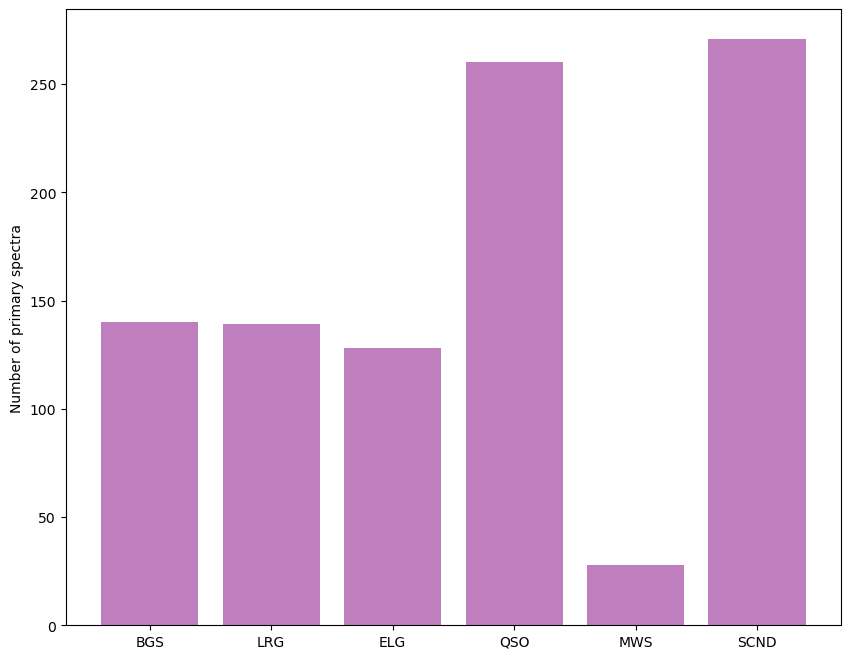

In [4]:
"""   
Trying the target masking code 

"""

# Targeting information about the DESI targetting is stored in the different desi_target columns
# sv1_targetmask.desi_mask corresponds to SV1_DESI_TARGET
# sv2_targetmask.desi_mask corresponds to SV2_DESI_TARGET
# sv3_targetmask.desi_mask corresponds to SV3_DESI_TARGET

sv1_desi_tgt = my_table['SV1_DESI_TARGET']
sv2_desi_tgt = my_table['SV2_DESI_TARGET']
sv3_desi_tgt = my_table['SV3_DESI_TARGET']

sv1_desi_mask = sv1_targetmask.desi_mask
sv2_desi_mask = sv2_targetmask.desi_mask
sv3_desi_mask = sv3_targetmask.desi_mask


# Selecting candidates - 
# The code below selects the individual targets observed in all the SV1, SV2, and SV3 tiles.

## All BGS targets from sv1, sv2, and sv3
is_bgs = (sv1_desi_tgt & sv1_desi_mask['BGS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['BGS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['BGS_ANY'] != 0)
## All LRG targets from sv1, sv2, and sv3
is_lrg = (sv1_desi_tgt & sv1_desi_mask['LRG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['LRG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['LRG'] != 0)
## All ELG targets from sv1, sv2, and sv3
is_elg = (sv1_desi_tgt & sv1_desi_mask['ELG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['ELG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['ELG'] != 0)
## All QSO targets from sv1, sv2, and sv3
is_qso = (sv1_desi_tgt & sv1_desi_mask['QSO'] != 0)|(sv2_desi_tgt & sv2_desi_mask['QSO'] != 0)|(sv3_desi_tgt & sv3_desi_mask['QSO'] != 0)
## All MWS targets from sv1, sv2, and sv3
is_mws = (sv1_desi_tgt & sv1_desi_mask['MWS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['MWS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['MWS_ANY'] != 0)
## All Secondary targets from sv1, sv2, and sv3
is_scnd = (sv1_desi_tgt & sv1_desi_mask['SCND_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['SCND_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['SCND_ANY'] != 0)

# Number of sources of each target type
n_bgs = len(my_table[is_bgs])
n_lrg = len(my_table[is_lrg])
n_elg = len(my_table[is_elg])
n_qso = len(my_table[is_qso])
n_mws = len(my_table[is_mws])
n_scnd = len(my_table[is_scnd])


# Let us look at the numbers visually - 

plt.figure(figsize = (10, 8))

targets = ['BGS', 'LRG', 'ELG', 'QSO', 'MWS', 'SCND']
numbers = [n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd]

plt.bar(targets, numbers, color = 'purple', alpha = 0.5)
plt.ylabel('Number of primary spectra')
#plt.yscale('log')

99


Text(0, 0.5, 'Number of primary spectra')

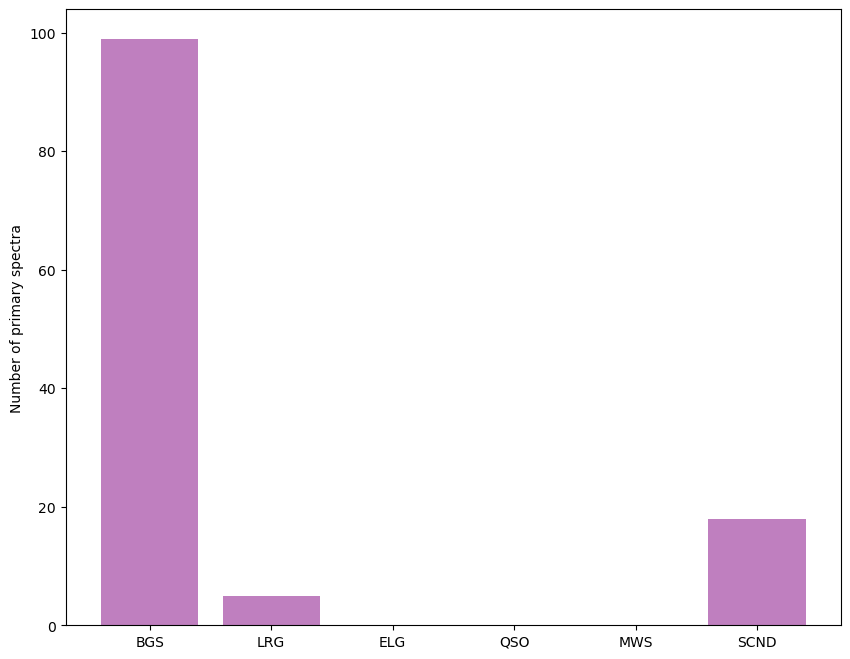

In [21]:
"""   
Trying the target masking code 

"""

# Targeting information about the DESI targetting is stored in the different desi_target columns
# sv1_targetmask.desi_mask corresponds to SV1_DESI_TARGET
# sv2_targetmask.desi_mask corresponds to SV2_DESI_TARGET
# sv3_targetmask.desi_mask corresponds to SV3_DESI_TARGET

sv1_desi_tgt = my_table_1['SV1_DESI_TARGET']
sv2_desi_tgt = my_table_1['SV2_DESI_TARGET']
sv3_desi_tgt = my_table_1['SV3_DESI_TARGET']

sv1_desi_mask = sv1_targetmask.desi_mask
sv2_desi_mask = sv2_targetmask.desi_mask
sv3_desi_mask = sv3_targetmask.desi_mask


# Selecting candidates - 
# The code below selects the individual targets observed in all the SV1, SV2, and SV3 tiles.

## All BGS targets from sv1, sv2, and sv3
is_bgs = (sv1_desi_tgt & sv1_desi_mask['BGS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['BGS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['BGS_ANY'] != 0)
## All LRG targets from sv1, sv2, and sv3
is_lrg = (sv1_desi_tgt & sv1_desi_mask['LRG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['LRG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['LRG'] != 0)
## All ELG targets from sv1, sv2, and sv3
is_elg = (sv1_desi_tgt & sv1_desi_mask['ELG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['ELG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['ELG'] != 0)
## All QSO targets from sv1, sv2, and sv3
is_qso = (sv1_desi_tgt & sv1_desi_mask['QSO'] != 0)|(sv2_desi_tgt & sv2_desi_mask['QSO'] != 0)|(sv3_desi_tgt & sv3_desi_mask['QSO'] != 0)
## All MWS targets from sv1, sv2, and sv3
is_mws = (sv1_desi_tgt & sv1_desi_mask['MWS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['MWS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['MWS_ANY'] != 0)
## All Secondary targets from sv1, sv2, and sv3
is_scnd = (sv1_desi_tgt & sv1_desi_mask['SCND_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['SCND_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['SCND_ANY'] != 0)

# Number of sources of each target type
n_bgs = len(my_table_1[is_bgs])
n_lrg = len(my_table_1[is_lrg])
n_elg = len(my_table_1[is_elg])
n_qso = len(my_table_1[is_qso])
n_mws = len(my_table_1[is_mws])
n_scnd = len(my_table_1[is_scnd])


print(n_bgs)
# Let us look at the numbers visually - 

plt.figure(figsize = (10, 8))

targets = ['BGS', 'LRG', 'ELG', 'QSO', 'MWS', 'SCND']
numbers = [n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd]

plt.bar(targets, numbers, color = 'purple', alpha = 0.5)
plt.ylabel('Number of primary spectra')
#plt.yscale('log')

(140, 139, 128, 260, 28, 271)
140


Text(0, 0.5, 'Number of primary spectra')

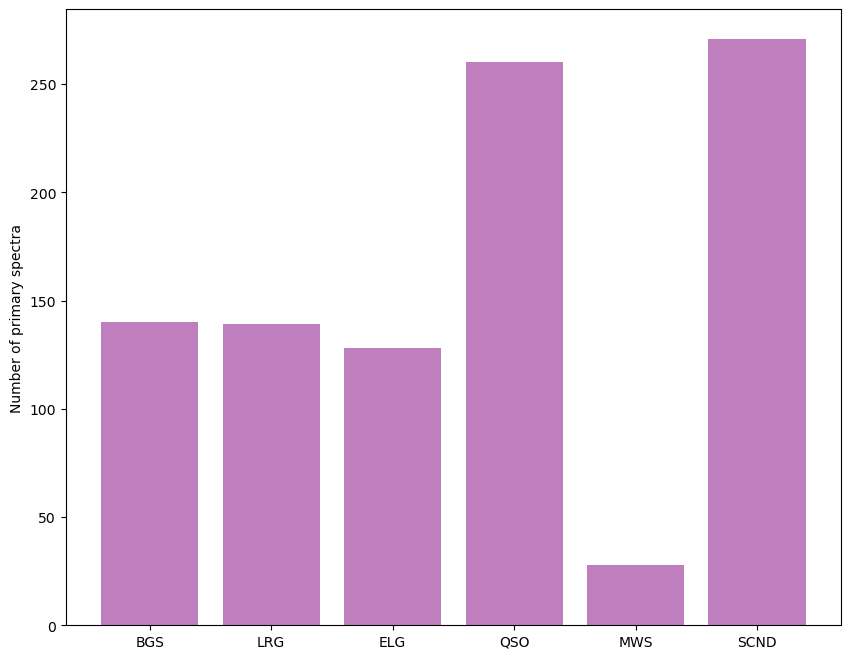

In [25]:
"""   
Trying the target masking code 

"""

# Targeting information about the DESI targetting is stored in the different desi_target columns
# sv1_targetmask.desi_mask corresponds to SV1_DESI_TARGET
# sv2_targetmask.desi_mask corresponds to SV2_DESI_TARGET
# sv3_targetmask.desi_mask corresponds to SV3_DESI_TARGET

def n_types(table):


    sv1_desi_tgt = table['SV1_DESI_TARGET']
    sv2_desi_tgt = table['SV2_DESI_TARGET']
    sv3_desi_tgt = table['SV3_DESI_TARGET']

    sv1_desi_mask = sv1_targetmask.desi_mask
    sv2_desi_mask = sv2_targetmask.desi_mask
    sv3_desi_mask = sv3_targetmask.desi_mask


    # Selecting candidates - 
    # The code below selects the individual targets observed in all the SV1, SV2, and SV3 tiles.

    ## All BGS targets from sv1, sv2, and sv3
    is_bgs = (sv1_desi_tgt & sv1_desi_mask['BGS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['BGS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['BGS_ANY'] != 0)
    ## All LRG targets from sv1, sv2, and sv3
    is_lrg = (sv1_desi_tgt & sv1_desi_mask['LRG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['LRG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['LRG'] != 0)
    ## All ELG targets from sv1, sv2, and sv3
    is_elg = (sv1_desi_tgt & sv1_desi_mask['ELG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['ELG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['ELG'] != 0)
    ## All QSO targets from sv1, sv2, and sv3
    is_qso = (sv1_desi_tgt & sv1_desi_mask['QSO'] != 0)|(sv2_desi_tgt & sv2_desi_mask['QSO'] != 0)|(sv3_desi_tgt & sv3_desi_mask['QSO'] != 0)
    ## All MWS targets from sv1, sv2, and sv3
    is_mws = (sv1_desi_tgt & sv1_desi_mask['MWS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['MWS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['MWS_ANY'] != 0)
    ## All Secondary targets from sv1, sv2, and sv3
    is_scnd = (sv1_desi_tgt & sv1_desi_mask['SCND_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['SCND_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['SCND_ANY'] != 0)

    # Number of sources of each target type
    n_bgs = len(table[is_bgs])
    n_lrg = len(table[is_lrg])
    n_elg = len(table[is_elg])
    n_qso = len(table[is_qso])
    n_mws = len(table[is_mws])
    n_scnd = len(table[is_scnd])

    return n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd

print(n_types(my_table))

n_bgs = []
n_lrg = []
n_elg = []
n_qso = []
n_mws = []
n_scnd = []

for table in tables:
    n_bgs.append(np.array(n_types(table)[0]))
    n_lrg.append(np.array(n_types(table)[1]))
    n_elg.append(np.array(n_types(table)[2]))
    n_qso.append(np.array(n_types(table)[3]))
    n_mws.append(np.array(n_types(table)[4]))
    n_scnd.append(np.array(n_types(table)[5]))


print(n_bgs[0])

# Let us look at the numbers visually - 

plt.figure(figsize = (10, 8))

targets = ['BGS', 'LRG', 'ELG', 'QSO', 'MWS', 'SCND']
numbers = [n_bgs[0], n_lrg[0], n_elg[0], n_qso[0], n_mws[0], n_scnd[0]]

plt.bar(targets, numbers, color = 'purple', alpha = 0.5)
plt.ylabel('Number of primary spectra')
#plt.yscale('log')

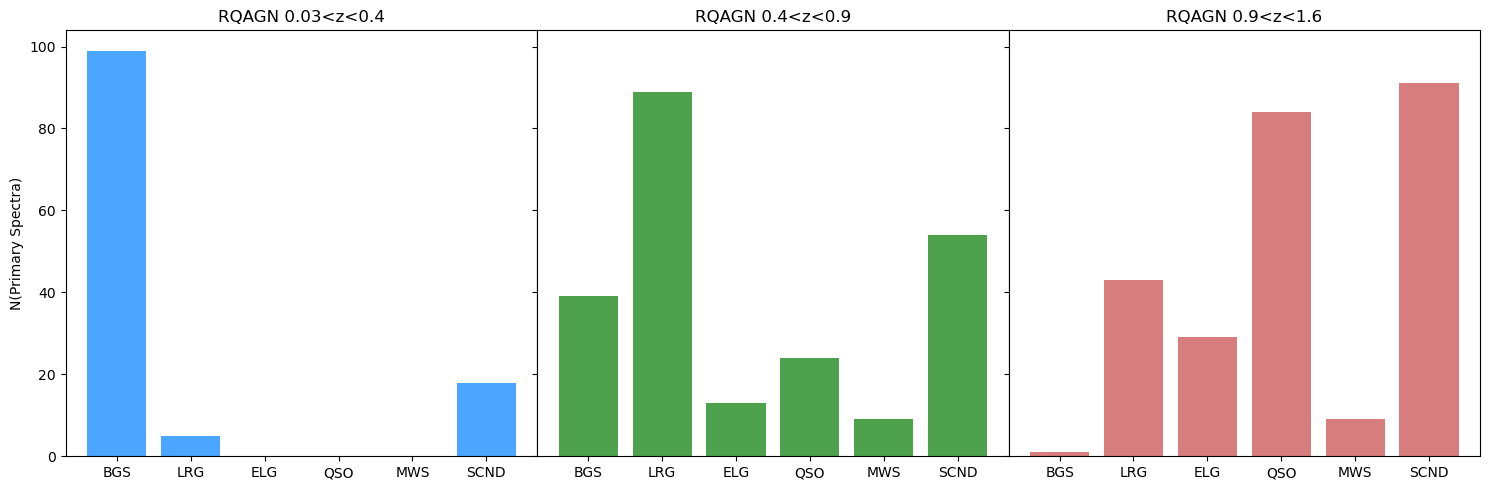

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5),sharey=True, sharex=False, gridspec_kw={'wspace': 0})


targets = ['BGS', 'LRG', 'ELG', 'QSO', 'MWS', 'SCND']

# Plot for my_table_1
numbers_1 = [n_bgs[1], n_lrg[1], n_elg[1], n_qso[1], n_mws[1], n_scnd[1]]

axs[0].bar(targets, numbers_1, color='dodgerblue', alpha=0.8)
axs[0].set_ylabel('N(Primary Spectra)')
axs[0].set_title(f'{Overall_class} 0.03<z<0.4')


# Plot for my_table_2
numbers_2 = [n_bgs[2], n_lrg[2], n_elg[2], n_qso[2], n_mws[2], n_scnd[2]]

axs[1].bar(targets, numbers_2, color='forestgreen', alpha=0.8)
axs[1].set_title(f'{Overall_class} 0.4<z<0.9')


# Plot for my_table_3
numbers_3 = [n_bgs[3], n_lrg[3], n_elg[3], n_qso[3], n_mws[3], n_scnd[3]]

axs[2].bar(targets, numbers_3, color='indianred', alpha=0.8)
axs[2].set_title(f'{Overall_class} 0.9<z<1.6')


plt.tight_layout()
plt.show()

In [9]:
from desitarget.targets import main_cmx_or_sv
column_names, masks, survey = main_cmx_or_sv(my_table)

#column_names
#masks
survey

'cmx'

(0.0, 50.0)

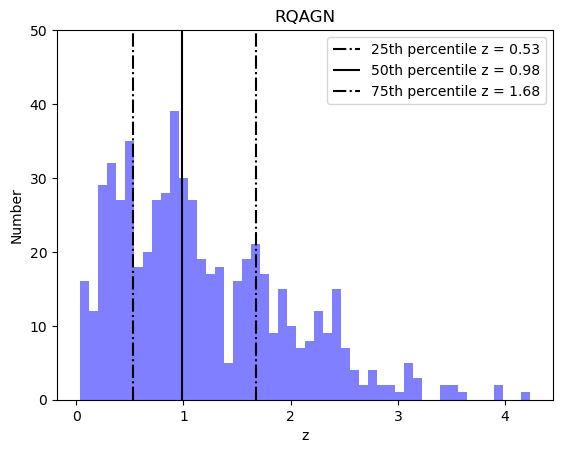

In [7]:
percentile_1 = 25
percentile_2 = 50
percentile_3 = 75
z_cut_1 = np.percentile(my_table['Z'], percentile_1)
z_cut_2 = np.percentile(my_table['Z'], percentile_2)
z_cut_3 = np.percentile(my_table['Z'], percentile_3)
ymax = 50

plt.hist(my_table['Z'], bins=50, color='blue', alpha = 0.5)
plt.xlabel('z')
plt.ylabel('Number')
plt.title(f'{Overall_class}')
plt.vlines(z_cut_1, ymin=0, ymax=ymax, colors='black', linestyles='-.', label = f'{percentile_1}th percentile z = {z_cut_1:.2f}')
plt.vlines(z_cut_2, ymin=0, ymax=ymax, colors='black', linestyles='-', label = f'{percentile_2}th percentile z = {z_cut_2:.2f}')
plt.vlines(z_cut_3, ymin=0, ymax=ymax, colors='black', linestyles='-.', label = f'{percentile_3}th percentile z = {z_cut_3:.2f}')
plt.legend()
plt.ylim(0,ymax)
#plt.xlim(0,2)

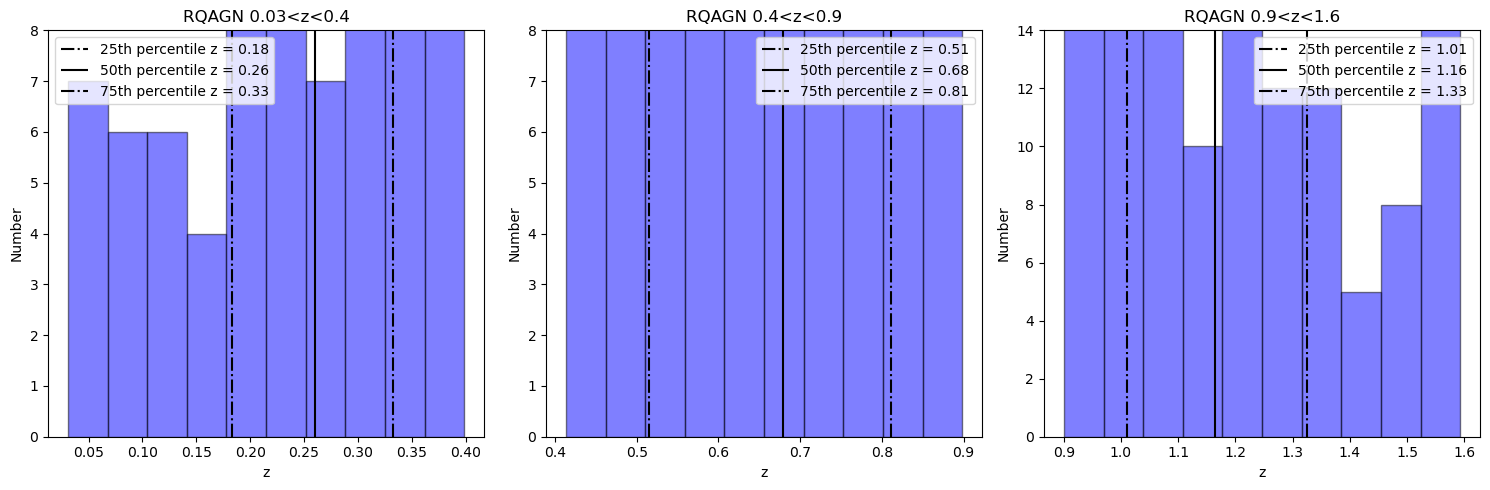

In [36]:



percentile_1 = 25
percentile_2 = 50
percentile_3 = 75
z_cut_1 = np.percentile(my_table_1['Z'], percentile_1)
z_cut_2 = np.percentile(my_table_1['Z'], percentile_2)
z_cut_3 = np.percentile(my_table_1['Z'], percentile_3)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for my_table_1
axs[0].hist(my_table_1['Z'], bins=10, color='blue', alpha=0.5, edgecolor='black')
axs[0].set_xlabel('z')
axs[0].set_ylabel('Number')
axs[0].set_title(f'{Overall_class} 0.03<z<0.4')
axs[0].vlines(z_cut_1, ymin=0, ymax=14, colors='black', linestyles='-.', label=f'{percentile_1}th percentile z = {z_cut_1:.2f}')
axs[0].vlines(z_cut_2, ymin=0, ymax=14, colors='black', linestyles='-', label=f'{percentile_2}th percentile z = {z_cut_2:.2f}')
axs[0].vlines(z_cut_3, ymin=0, ymax=14, colors='black', linestyles='-.', label=f'{percentile_3}th percentile z = {z_cut_3:.2f}')
axs[0].legend()
axs[0].set_ylim(0, 8)

# Plot for my_table_2
z_cut_1 = np.percentile(my_table_2['Z'], percentile_1)
z_cut_2 = np.percentile(my_table_2['Z'], percentile_2)
z_cut_3 = np.percentile(my_table_2['Z'], percentile_3)

axs[1].hist(my_table_2['Z'], bins=10, color='blue', alpha=0.5, edgecolor='black')
axs[1].set_xlabel('z')
axs[1].set_ylabel('Number')
axs[1].set_title(f'{Overall_class} 0.4<z<0.9')
axs[1].vlines(z_cut_1, ymin=0, ymax=14, colors='black', linestyles='-.', label=f'{percentile_1}th percentile z = {z_cut_1:.2f}')
axs[1].vlines(z_cut_2, ymin=0, ymax=14, colors='black', linestyles='-', label=f'{percentile_2}th percentile z = {z_cut_2:.2f}')
axs[1].vlines(z_cut_3, ymin=0, ymax=14, colors='black', linestyles='-.', label=f'{percentile_3}th percentile z = {z_cut_3:.2f}')
axs[1].legend()
axs[1].set_ylim(0, 8)

# Plot for my_table_3
z_cut_1 = np.percentile(my_table_3['Z'], percentile_1)
z_cut_2 = np.percentile(my_table_3['Z'], percentile_2)
z_cut_3 = np.percentile(my_table_3['Z'], percentile_3)

axs[2].hist(my_table_3['Z'], bins=10, color='blue', alpha=0.5, edgecolor='black')
axs[2].set_xlabel('z')
axs[2].set_ylabel('Number')
axs[2].set_title(f'{Overall_class} 0.9<z<1.6')
axs[2].vlines(z_cut_1, ymin=0, ymax=14, colors='black', linestyles='-.', label=f'{percentile_1}th percentile z = {z_cut_1:.2f}')
axs[2].vlines(z_cut_2, ymin=0, ymax=14, colors='black', linestyles='-', label=f'{percentile_2}th percentile z = {z_cut_2:.2f}')
axs[2].vlines(z_cut_3, ymin=0, ymax=14, colors='black', linestyles='-.', label=f'{percentile_3}th percentile z = {z_cut_3:.2f}')
axs[2].legend()
axs[2].set_ylim(0, 14)

plt.tight_layout()
plt.show()



In [31]:
print(np.min(my_table['Z']))

0.030947554662133173


In [8]:
# Read stack.csv
stacks_df_1 = pd.read_csv(f'{Overall_class}_stacks_1.csv')
stacks_1 = (stacks_df_1['wave_spec_1'].values, stacks_df_1['flux_spec_1'].values)

wln_1 = stacks_1[0] 
flux_1 = stacks_1[1]

stacks_df_2 = pd.read_csv(f'{Overall_class}_stacks_2.csv')
stacks_2 = (stacks_df_2['wave_spec_2'].values, stacks_df_2['flux_spec_2'].values)

wln_2 = stacks_2[0]
flux_2 = stacks_2[1]

stacks_df_3 = pd.read_csv(f'{Overall_class}_stacks_3.csv')
stacks_3 = (stacks_df_3['wave_spec_3'].values, stacks_df_3['flux_spec_3'].values)

wln_3 = stacks_3[0]
flux_3 = stacks_3[1]

## Plot Stacked Spectra

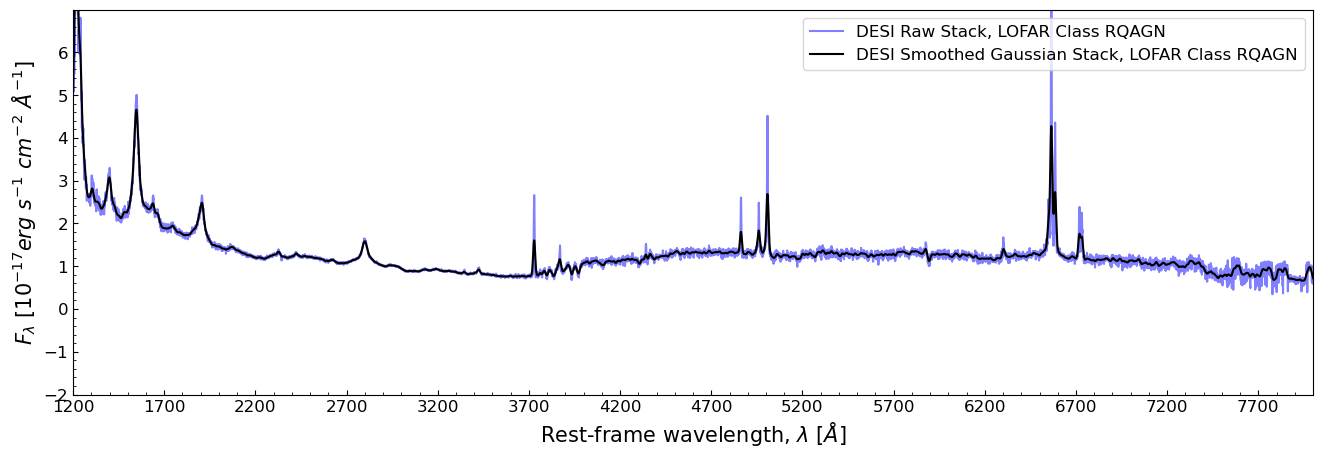

All plots saved in DESI-RQAGN-stack_Final.pdf


In [68]:
# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stack_Final.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.plot(wln,flux, color='blue', alpha=0.5,label = f'DESI Raw Stack, LOFAR Class {Overall_class}')
        ax.plot(wln,convolve(flux, Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}')
        ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.set_xlim(1200,8000)
        ax.set_ylim(-2,7)
        ax.set_xticks(range(1200, 8001, 500))
        ax.set_yticks(range(-2, 7, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
        ax.minorticks_on()
        ax.legend(fontsize='large', loc = 'upper right')
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.show()
        plt.close()

# All the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')



In [16]:
def renorm1(flux, wln, wln_norm):
    """
    Normalises the flux at a given wavelength
    """
    index_norm = np.abs(wln - wln_norm).argmin()
    print('wln_norm=',wln[index_norm])
    
    flux_norm = flux / flux[index_norm]
    return flux_norm


def renorm(flux, wln, wln_min, wln_max):
    """
    Normalizes the flux to the median wavelength in the specified range
    """
    indices = np.where((wln >= wln_min) & (wln <= wln_max))

    flux_norm = flux / np.median(flux[indices])
    
    return flux_norm

wln_min = 4500
wln_max = 4700

flux_1_norm = renorm(flux_1, wln_1, wln_min, wln_max)
flux_2_norm = renorm(flux_2, wln_2, wln_min, wln_max)
flux_3_norm = renorm(flux_3, wln_3, wln_min, wln_max)

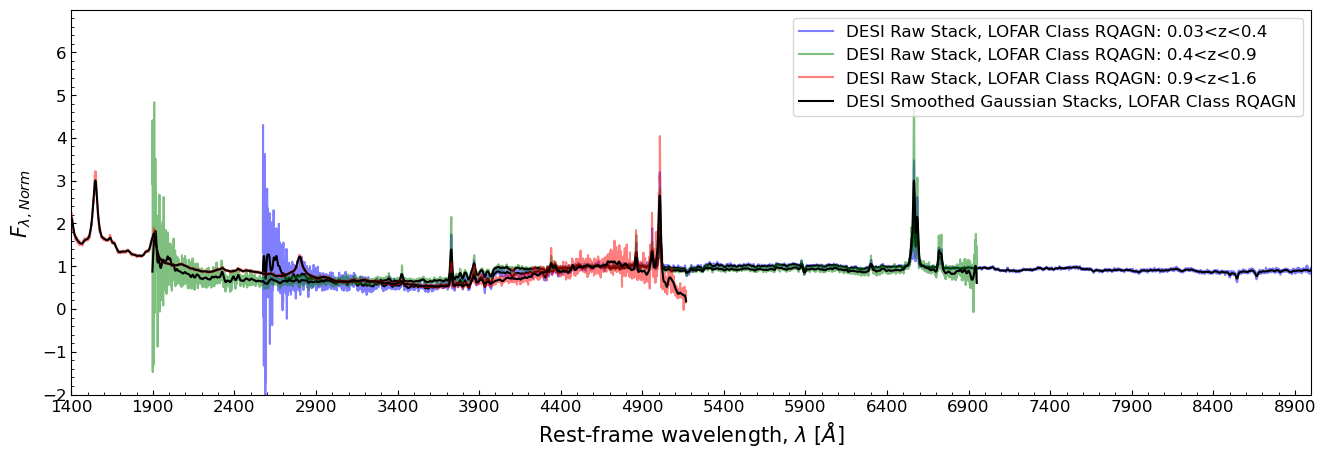

All plots saved in DESI-RQAGN-stacked-zbin-plots-uncut-final.pdf


In [17]:
"""

"""





# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-zbin-plots-uncut-final.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.plot(wln_1,flux_1_norm, label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.03<z<0.4', color='blue', alpha=0.5)
        ax.plot(wln_1,convolve(flux_1_norm, Gaussian1DKernel(5)), color='black', alpha=1)
        ax.plot(wln_2,flux_2_norm, label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.4<z<0.9', color='green', alpha=0.5)
        ax.plot(wln_2,convolve(flux_2_norm, Gaussian1DKernel(5)), color='black', alpha=1)
        ax.plot(wln_3,flux_3_norm, label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.9<z<1.6', color='red', alpha=0.5)
        ax.plot(wln_3,convolve(flux_3_norm, Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stacks, LOFAR Class {Overall_class}')
        ax.set_ylabel('$F_{\lambda, Norm}$ ')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.set_xlim(1400,9000)
        ax.set_ylim(-2,7)
        ax.set_xticks(range(1400, 9001, 500))
        ax.set_yticks(range(-2, 7, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
        ax.minorticks_on()
        ax.legend(fontsize='large', loc = 'upper right')
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.show()
        plt.close()

# After the loop, all the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')




In [18]:

"""

Add in some bounds to remove the upper and lower 10% of each spectra as noise reduction

"""

def bounds(stack_array):
        bound = 0.1
        l_bound = len(stack_array)*bound
        u_bound = len(stack_array)-(len(stack_array)*bound)

        return int(l_bound), int(u_bound)


st1 = bounds(wln_1)
st2 = bounds(wln_2)
st3 = bounds(wln_3)

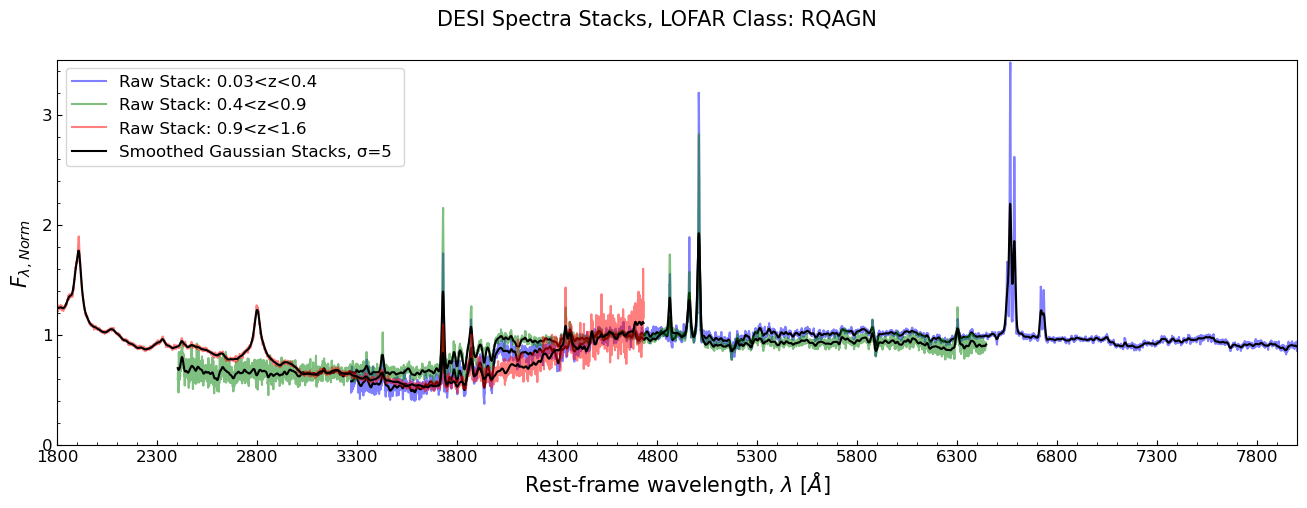

All plots saved in DESI-RQAGN-stacked-zbin-plots-0.1cut-final.pdf


In [32]:
# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-zbin-plots-0.1cut-final.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.plot(wln_1[st1[0]:st1[1]],flux_1_norm[st1[0]:st1[1]], label = f'Raw Stack: 0.03<z<0.4', color='blue', alpha=0.5)
        ax.plot(wln_1[st1[0]:st1[1]],convolve(flux_1_norm, Gaussian1DKernel(5))[st1[0]:st1[1]], color='black', alpha=1)
        ax.plot(wln_2[st2[0]:st2[1]],flux_2_norm[st2[0]:st2[1]], label = f'Raw Stack: 0.4<z<0.9', color='green', alpha=0.5)
        ax.plot(wln_2[st2[0]:st2[1]],convolve(flux_2_norm, Gaussian1DKernel(5))[st2[0]:st2[1]], color='black', alpha=1)
        ax.plot(wln_3[st3[0]:st3[1]],flux_3_norm[st3[0]:st3[1]], label = f'Raw Stack: 0.9<z<1.6', color='red', alpha=0.5)
        ax.plot(wln_3[st3[0]:st3[1]],convolve(flux_3_norm, Gaussian1DKernel(5))[st3[0]:st3[1]], color='black', alpha=1, label = f'Smoothed Gaussian Stacks, \u03C3=5 ')
        ax.set_ylabel('$F_{\lambda, Norm}$ ')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.set_xlim(1800,8000)
        ax.set_ylim(0.2,3.5)
        ax.set_xticks(range(1800, 8001, 500))
        ax.set_yticks(range(0, 4, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
        ax.minorticks_on()
        ax.legend(fontsize='large', loc = 'upper left')
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)
        fig.suptitle(f'DESI Spectra Stacks, LOFAR Class: {Overall_class}', fontsize=15)

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.show()
        plt.close()

# After the loop, all the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')

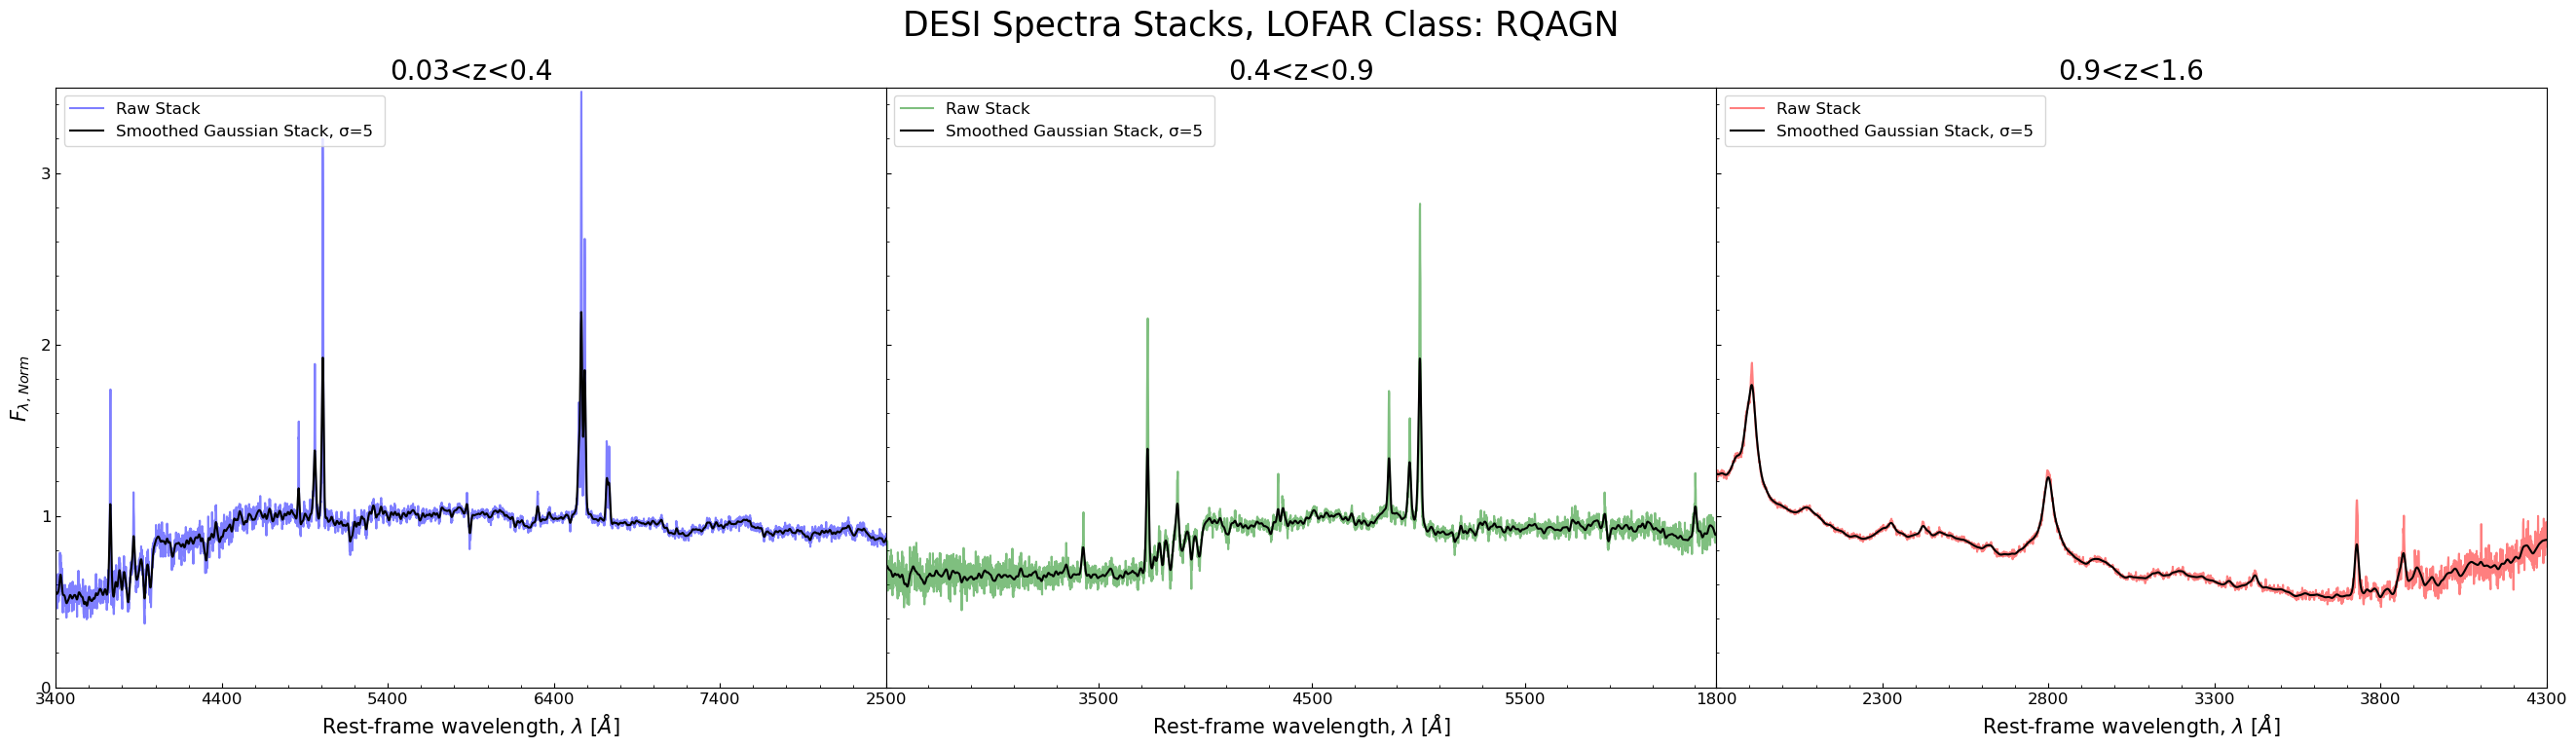

All plots saved in DESI-RQAGN-stacked-zbin-plots-0.1cut_split_final.pdf


In [33]:
#### change the order of the plots to be in order of redshift



# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-zbin-plots-0.1cut_split_final.pdf'
with PdfPages(pdf_filename) as pdf:
    # Create a 1x3 grid of subplots with no spacing between plots
    fig, axs = plt.subplots(1, 3, figsize=(33,8), sharey=True, sharex=False, gridspec_kw={'wspace': 0})
    
    # Plot for column 1 (flux_1)
    axs[0].plot(wln_1[st1[0]:st1[1]], flux_1_norm[st1[0]:st1[1]], label=f'Raw Stack', color='blue', alpha=0.5)
    axs[0].plot(wln_1[st1[0]:st1[1]], convolve(flux_1_norm, Gaussian1DKernel(5))[st1[0]:st1[1]], color='black', alpha=1, label=f'Smoothed Gaussian Stack, \u03C3=5 ')
    axs[0].set_xlim(3400, 8400)
    axs[0].set_xticks(range(3400, 8399, 1000))
    axs[0].set_title('0.03<z<0.4', fontsize=20)
    
    # Plot for column 2 (flux_2)
    axs[1].plot(wln_2[st2[0]:st2[1]], flux_2_norm[st2[0]:st2[1]], label=f'Raw Stack', color='green', alpha=0.5)
    axs[1].plot(wln_2[st2[0]:st2[1]], convolve(flux_2_norm, Gaussian1DKernel(5))[st2[0]:st2[1]], color='black', alpha=1, label=f'Smoothed Gaussian Stack, \u03C3=5 ')
    axs[1].set_xlim(2500, 6400)
    axs[1].set_xticks(range(2500, 6401, 1000))
    axs[1].set_title('0.4<z<0.9', fontsize=20)

    # Plot for column 3 (flux_3)
    axs[2].plot(wln_3[st3[0]:st3[1]], flux_3_norm[st3[0]:st3[1]], label=f'Raw Stack', color='red', alpha=0.5)
    axs[2].plot(wln_3[st3[0]:st3[1]], convolve(flux_3_norm, Gaussian1DKernel(5))[st3[0]:st3[1]], color='black', alpha=1, label=f'Smoothed Gaussian Stack, \u03C3=5 ')
    axs[2].set_xlim(1800, 4300)
    axs[2].set_xticks(range(1800, 4301, 500))
    axs[2].set_title('0.9<z<1.6', fontsize=20)

    # Customize common settings for all subplots
    for i, ax in enumerate(axs):
        ax.set_ylabel('$F_{\lambda, Norm}$ ')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        #ax.set_xlim(1100, 8500)
        ax.set_ylim(0.2, 3.5)
        #ax.set_xticks(range(1100, 8501, 1000))  # Adjust the tick values
        ax.set_yticks(range(0, 4, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction='in')
        ax.minorticks_on()
        if i != 0:
            ax.set_ylabel('')
        ax.legend(fontsize='large', loc='upper left')  # Adjust the legend location
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)
    
    fig.suptitle(f'DESI Spectra Stacks, LOFAR Class: {Overall_class}', fontsize=25)

    
    # Save the current plot to the PDF file
    pdf.savefig(fig)
    plt.show()
    plt.close()

# After the loop, all the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')




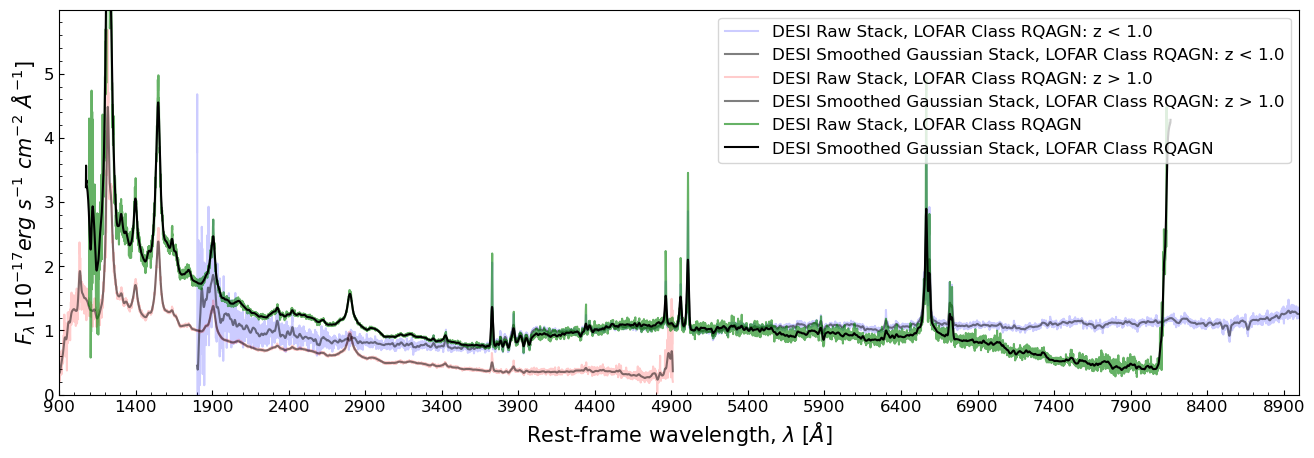

All plots saved in DESI-RQAGN-stacked-zbin-plots-all.pdf


In [19]:




# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-zbin-plots-all.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.plot(SFG_stacks['zbin=0']['wln'][st0[0]:st0[1]],SFG_stacks['zbin=0']['flux'][st0[0]:st0[1]], label = f'DESI Raw Stack, LOFAR Class {Overall_class}: z < 1.0', color='blue', alpha=0.2)
        ax.plot(SFG_stacks['zbin=0']['wln'][st0[0]:st0[1]],convolve(SFG_stacks['zbin=0']['flux'][st0[0]:st0[1]], Gaussian1DKernel(5)), color='black', alpha=0.5, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: z < 1.0')
        ax.plot(SFG_stacks['zbin=1']['wln'][st1[0]:st1[1]],SFG_stacks['zbin=1']['flux'][st1[0]:st1[1]], label = f'DESI Raw Stack, LOFAR Class {Overall_class}: z > 1.0', color='red', alpha=0.2)
        ax.plot(SFG_stacks['zbin=1']['wln'][st1[0]:st1[1]],convolve(SFG_stacks['zbin=1']['flux'][st1[0]:st1[1]], Gaussian1DKernel(5)), color='black', alpha=0.5, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: z > 1.0')
        ax.plot(SFG_stack['zbin=0']['wln'][st2[0]:st2[1]],SFG_stack['zbin=0']['flux'][st2[0]:st2[1]], color='green', alpha=0.6,label = f'DESI Raw Stack, LOFAR Class {Overall_class}')
        ax.plot(SFG_stack['zbin=0']['wln'][st2[0]:st2[1]],convolve(SFG_stack['zbin=0']['flux'][st2[0]:st2[1]], Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}')
        ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.set_xlim(900,9000)
        ax.set_ylim(0,6)
        ax.set_xticks(range(900, 9001, 500))
        ax.set_yticks(range(0, 6, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
        ax.minorticks_on()
        ax.legend(fontsize='large', loc = 'upper right')
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.show()
        plt.close()


# After the loop, all the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')